In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("mnist").getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')
print type(df)
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0, 0.0, 0.0, 0...|    5|
|[0.0, 0.0, 0.0, 0...|    0|
|[0.0, 0.0, 0.0, 0...|    4|
|[0.0, 0.0, 0.0, 0...|    1|
|[0.0, 0.0, 0.0, 0...|    9|
|[0.0, 0.0, 0.0, 0...|    2|
|[0.0, 0.0, 0.0, 0...|    1|
|[0.0, 0.0, 0.0, 0...|    3|
|[0.0, 0.0, 0.0, 0...|    1|
|[0.0, 0.0, 0.0, 0...|    4|
|[0.0, 0.0, 0.0, 0...|    3|
|[0.0, 0.0, 0.0, 0...|    5|
|[0.0, 0.0, 0.0, 0...|    3|
|[0.0, 0.0, 0.0, 0...|    6|
|[0.0, 0.0, 0.0, 0...|    1|
|[0.0, 0.0, 0.0, 0...|    7|
|[0.0, 0.0, 0.0, 0...|    2|
|[0.0, 0.0, 0.0, 0...|    8|
|[0.0, 0.0, 0.0, 0...|    6|
|[0.0, 0.0, 0.0, 0...|    9|
+--------------------+-----+
only showing top 20 rows



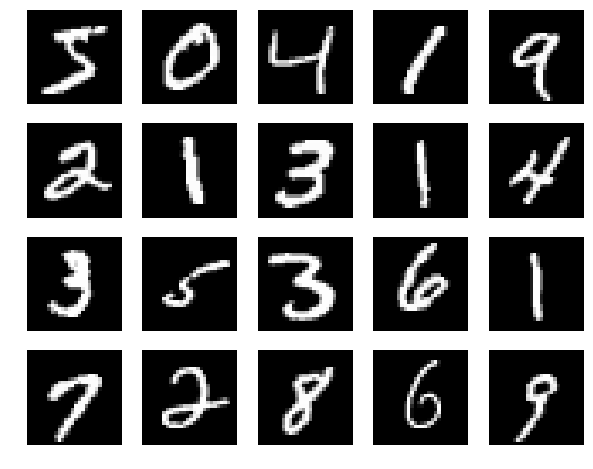

In [3]:
import numpy as np
from __future__ import division
# display the images
%matplotlib inline 
import matplotlib.pyplot as plt
def plot_digit(nrows, ncols, subset):
    plt.figure(figsize = (ncols*2, nrows*2))
    for i in xrange(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(subset[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.show()
    
    
nrows = 4
ncols = 5
# create subset
dataRDD = df.rdd.map(lambda x: np.array(x['features']))
subset = np.array(dataRDD.take(nrows * ncols))
plot_digit(nrows, ncols, subset)
    


# Part 1: PCA
a) Extract Principal components

In [5]:
# Standardize data
feature_mean = dataRDD.mean()
feature_std = dataRDD.stdev()
def standardize(x):
    for idx in range(len(x)):
        if feature_std[idx] == 0:
            x[idx] = x[idx] - feature_mean[idx]
        else:
            x[idx] = (x[idx] - feature_mean[idx])/feature_std[idx]
    return x
train_size = 30000
data = np.array(dataRDD.map(standardize).take(train_size))
print data.shape

(30000, 784)


In [6]:
#Compute the eigenvectors and eigenvalues of the covariance matrix
cov_mat = np.cov(data.T)
val, vec = np.linalg.eigh(cov_mat) 

Eigenvalues correspond to the first 10 principal components are:
[ 41.55273458  29.77964867  27.29230339  21.03582503  18.42882503
  15.96379171  14.30913782  12.77559775  11.39233998  10.31619863]
The first 10 principal components are:


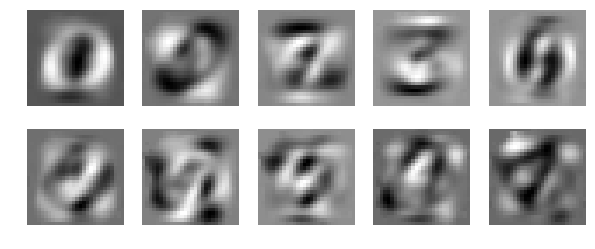

In [7]:
#Plot the first 10 eigenvalues and their corresponding eigenvalues
data_dim = len(vec)
val = val[::-1]
print 'Eigenvalues correspond to the first 10 principal components are:\n', val[:10]
vec = vec[:, ::-1]
print 'The first 10 principal components are:'
plot_digit(2, 5, vec[:,:10].T)

b) Plot variance

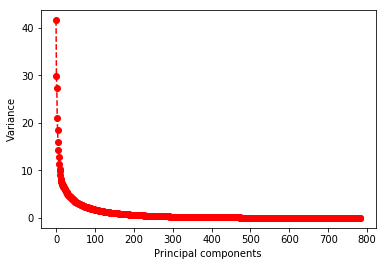

In [8]:
plt.plot([i for i in range(data_dim)], val, 'ro--')
plt.ylabel('Variance')
plt.xlabel('Principal components')
plt.show()
# The elbow is near m = 50

c) Dimension reduction

In this part of problem, we study the effect of principal component numbers near the elbow point (from 10 to 130) we used to do the dimension reduction. The principal components corresponding the directions with most variations. The more principal components we used, the less information of original data we lose and the better we can reconstruct the digit image. Previous graph shows that almost the first 50 pc contains the major information of the digit image. Here, we recover this fact by looking at the compressed image with m = 50, where we can almost recognize the digit.

Original data and reconstructed plots with number of principal components: m = 10, 30, 50, 70, 90, 110, 130:


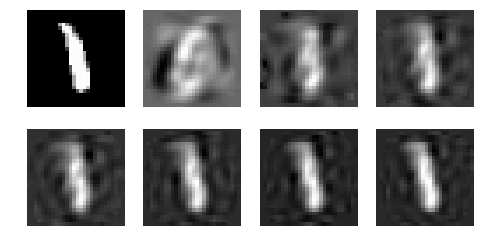

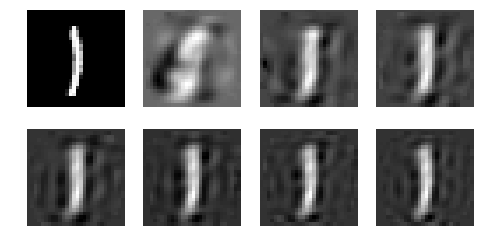

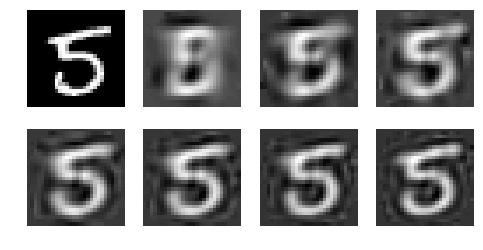

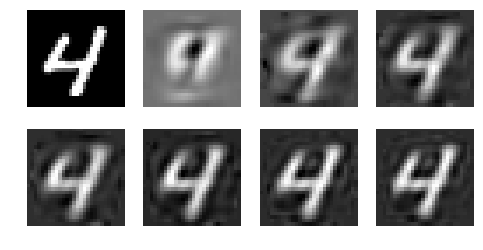

In [9]:
def dimension_reduction(m, x):
    vec_m = vec[:,:m]
    return np.dot(vec_m, np.dot(vec_m.T, x))
def principal_components(x):
    image_list = [x]
    for m in range(10, 140, 20):
        image_list.append(dimension_reduction(m, x))
    plot_digit(2,4,image_list)

test_data = np.array(dataRDD.sample(False, 0.5 * 1e-4).collect())
print 'Original data and reconstructed plots with number of principal components: m = 10, 30, 50, 70, 90, 110, 130:'
for x in test_data:
    principal_components(x)

d) Plot reconstruction error

The reconstruction error decrease decreases as the principal component number increases, as expected.

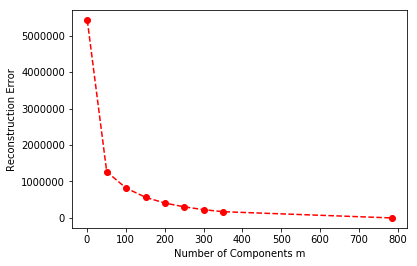

In [10]:
def cal_residual(data):
    org, red = data[0], data[1]
    diff = red - org
    return np.dot(diff.T, diff)
m_range = [m for m in range(1,400,50)] + [784]
residuals = []
for m in m_range:
    residuals.append(dataRDD.map(lambda x: (x, dimension_reduction(m, x))).map(cal_residual).reduce(lambda a, b: a + b))
plt.plot(m_range, residuals, 'ro--')
plt.ylabel('Reconstruction Error')
plt.xlabel('Number of Components m')
plt.show()

# Part 2: Kmeans

In this part, we use the first 50 principal components to compress the data and then run k-means for clustering images to 10 groups. The following image shows the centers for 10 groups. 

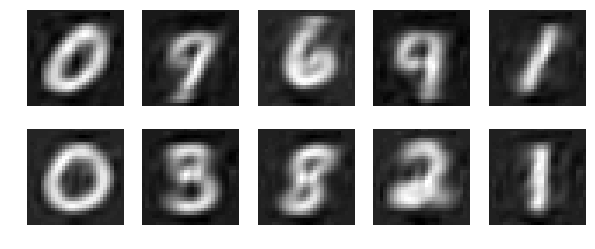

In [23]:
from pyspark.mllib.clustering import KMeans
comp_dim = 50
def compression(m, x):
    vec_m = vec[:,:m]
    return np.dot(vec_m.T, x)
data_kmean = dataRDD.map(lambda x: compression(comp_dim, x))
clusters = KMeans.train(data_kmean, 10, maxIterations=50, initializationMode="random")
centers = np.array(clusters.clusterCenters)
#print labels.shape
plot_digit(2, 5, np.dot(centers, vec[:,:comp_dim].T))

In [24]:
pred_label = clusters.predict(data_kmean)

In [25]:
from collections import Counter
def get_majority(x):
    ct = Counter(x).most_common(1)
    return (ct[0][0], ct[0][1]/len(x)) 
    
labels = df.rdd.map(lambda x: x['label'])
cb_label = pred_label.zip(labels).groupByKey().mapValues(get_majority).collect()
print 'The majority label and its percentage for each clusters are:'
for key, val in cb_label:
    print "%d: %d, %.4f" % (key, val[0], val[1])



The majority label and its percentage for each clusters are:
0: 0, 0.8205
1: 7, 0.4206
2: 6, 0.8614
3: 4, 0.3634
4: 1, 0.5604
5: 0, 0.8870
6: 3, 0.5305
7: 8, 0.5046
8: 2, 0.8944
9: 1, 0.5758


Notes on the output above: taking first row "0: 0, 0.8205" as an example, the first number "0" stands for the label of this cluster, i.e., true digits; the second number "0" stands for the label of the most frequent digits in this cluster after K means train; the third number "0.8205" stands for the percentage of the most frequent digits in this cluster.

By comparing the above two sections, we recognize clustering center images as the majority label in its group, which indicates that kmeans algorithm works with compressed data m = 50. Some of the digits work well like 0. However some of them work poorly, such as 5. We also notice that we have two groups of number one, both have around 50% majority vote. This is becuase we start from random and this is not necessarily the optimized clustering result. 

# Part 3: Spectral clustering
Here, we give a count table in which each row corresponds to clustering group and each column corresponds to true digits from 0 to 9. We change the h from 1 to 10000. When h = 10, most of digits are grouped to one cluster and the result is very poor. As h increases up to 1000, the clustering behavior seems to be much better.

In [14]:
import math
sc_size = 3000
sc_data = np.array(dataRDD.take(sc_size))
sc_label = np.array(df.rdd.map(lambda x: x['label']).take(sc_size))
m = 10
h = 1000
def cal_Lap(sc_data, sc_size, h):
    A = np.ones((sc_size, sc_size))
    for i in range(sc_size):
        for j in range(i + 1, sc_size):
            diff = sc_data[i] - sc_data[j]
            A[i][j] = np.exp(-np.dot(diff, diff)/h)
            A[j][i] = A[i][j]
    D = [1/math.sqrt(np.sum(Ai)) for Ai in A]
    for i in range(sc_size):
        for j in range(i, sc_size):
            A[i][j] *= D[i] * D[j]
            A[j][i] = A[i][j]
    L = np.diag(np.ones(sc_size)) - A
    sc_val, sc_vec = np.linalg.eigh(L) 
    return sc_val, sc_vec

def spectral_cluster(sc_vec, m):
    sc_vec_m_rdd =spark.sparkContext.parallelize(sc_vec[:,1:m], 28)
    clusters = KMeans.train(sc_vec_m_rdd, 10, maxIterations=50, initializationMode="random")
    labels = clusters.predict(sc_vec_m_rdd).collect()
    res = zip(labels, sc_label)
    ct = np.zeros((10, 10))
    for x in res:
        ct[x[0]][x[1]] += 1
    return ct
h_list = [10, 100, 1000, 10000]
for h in h_list:
    print '\nh is %d:\n' % h
    sc_val, sc_vec = cal_Lap(sc_data, sc_size, h)
    print spectral_cluster(sc_vec, m)



h is 10:

[[  86.  339.  288.  266.  324.  239.  300.  328.  251.  285.]
 [   0.    0.    0.    0.    0.    0.    4.    0.    0.    0.]
 [   0.    0.    0.    1.    1.    0.    1.    1.    0.    0.]
 [ 199.    0.    1.   20.    0.   29.    1.    0.    9.    2.]
 [   0.    0.    0.    1.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    2.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    7.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    3.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    5.    0.    5.    0.    0.    1.    0.]]

h is 100:

[[   9.    0.   19.  191.    0.   83.    0.    0.   70.    6.]
 [   0.  183.   13.    1.    7.   10.    4.   15.   11.    5.]
 [   8.    0.   21.    2.    8.    7.  240.    1.    3.    1.]
 [   2.    1.    3.   16.   84.   31.    1.    8.  144.  144.]
 [   1.    1.    9.    3.    1.    0.    0.  224.    0.    7.]
 [   2.  153.   26.   31.   10.

Notes on the output table above: Taking 

h is 10:
[[  86.  339.  288.  266.  324.  239.  300.  328.  251.  285.]
 [   0.    0.    0.    0.    0.    0.    4.    0.    0.    0.]
 [   0.    0.    0.    1.    1.    0.    1.    1.    0.    0.]
 [ 199.    0.    1.   20.    0.   29.    1.    0.    9.    2.]
 [   0.    0.    0.    1.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    2.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    7.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    3.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    5.    0.    5.    0.    0.    1.    0.]]
 
 as an example, the first row "[  86.  339.  288.  266.  324.  239.  300.  328.  251.  285.]" means that: 86 true "0", 339 true "1", 288 true "2", 266 true "3", 324 true "4", 239 true "5", 300 true "6", 328 true "7", 251 true "8", 285 true "9" are clusterd into one cluster, which obviously is poor.

# Part 4: Classification

## (a) Multinomial logistic regression

In [26]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
train, dev, test = df.rdd.randomSplit([4, 1, 1])
train_labeled = train.map(lambda x: LabeledPoint(x['label'], x['features']))
model = LogisticRegressionWithLBFGS.train(train_labeled, iterations=100, numClasses=10)

In [137]:
dev_label = dev.map(lambda x: x['label']).collect()
def get_error_rate(log_model, data, label):
    size = len(label)
    predicted_label = log_model.predict(data).collect()
    error_rate = np.sum(np.array(predicted_label) != np.array(label)) / dev_size
    return error_rate
print 'Error rate with raw data is %.04f.' % get_error_rate(model, dev.map(lambda x: x['features']), dev_label)

Error rate with raw data is 0.0873.


## (b) error vs number of principal components used

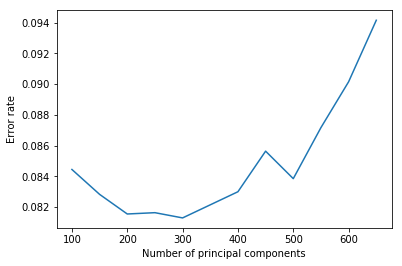

In [131]:
m_range = [i for i in range(100, 700, 50)]
error_rate = []
for m in m_range:
    train_m = train.map(lambda x: LabeledPoint(x['label'], compression(m, x['features'])))
    model_m = LogisticRegressionWithLBFGS.train(train_m, iterations=100, numClasses=10)
    dev_m = dev.map(lambda x: compression(m, x['features']))
    error_rate.append(get_error_rate(model_m, dev_m, dev_label))
plt.plot(m_range, error_rate)
plt.xlabel('Number of principal components')
plt.ylabel('Error rate')
plt.show()

In [138]:
print zip(m_range, error_rate)

[(100, 0.084447092874776544), (150, 0.082829658636247555), (200, 0.081552736868987827), (250, 0.081637864986805142), (300, 0.081297352515535881), (350, 0.082148633693709033), (400, 0.082999914871882186), (450, 0.085638886524218943), (500, 0.083851196050055338), (550, 0.087171192644930617), (600, 0.09015067676853665), (650, 0.094151698305950451)]


The error rate first decrease, then increase with m, leading to a minimum error rate located at m = 300. We then choose m = 300, which minimize the error on the developemnt data, to retrain the combined trainint and development data. The corresponding error rate is 7.75%, which is lower than that with raw data. This is because the high dimensionality in data will affect the performance of regression algrithm. Getting rid of unimportant features will improve the model result as shown here.

## (c) pick best k

In [144]:
m_opt = 300
new_train = train.union(dev).map(lambda x: LabeledPoint(x['label'], compression(m_opt, x['features'])))
model = LogisticRegressionWithLBFGS.train(new_train, iterations=100, numClasses=10)
test_m = test.map(lambda x: compression(m_opt, x['features']))
test_label = test.map(lambda x: x['label']).collect()
print 'Error rate with data compressed with %d pc is %.04f.' % (m_opt, get_error_rate(model, test_m, test_label))

Error rate with data compressed with 300 pc is 0.0775.


Comments: The error rate is 

In [ ]:
spark.stop()